# test stage2_443076_m3 lick rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import cv2
from PIL import Image
import plotly.express as px
import imagecodecs
from matplotlib.animation import FuncAnimation
import tkinter as tk
from tkinter import filedialog
import os
import re

In [2]:
def licked_txt(file_path, stage):
    if stage == "stage1":
        footer = 3
    else:
        footer = 4
        
    total_lines = sum(1 for line in open(file_path)) # Determine the total number of lines in the file

    data_txt = np.genfromtxt(file_path, delimiter='\t', skip_footer=footer)  # Read the text file into a NumPy array, excluding the last 3 rows

    licked = data_txt[:, 4]
    flash_type = data_txt[:, 2]

    success = []
    if stage == "stage3":
        success = data_txt[:, 5]

    return licked, data_txt, flash_type, success


# In[63]:

def load_files_from_folder(folder_path, stage):
    files = os.listdir(folder_path)
    file_data = {}
    for file_name in files:
        # Extract day number from the file name using regular expressions
        match = re.search(r'day(\d+)', file_name)
        if match:
            day_number = int(match.group(1))
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                print("Loading file:", file_path)
                # Read file data and store it in a dictionary with variable names
                file_data[f'day{day_number}'] = licked_txt(file_path, stage)
    return file_data

# In[64]:


def select_folder(stage):
    folder_path = filedialog.askdirectory()
    if folder_path:
        print("Selected folder:", folder_path)
        file_data = load_files_from_folder(folder_path, stage)
        print("Processing complete.")
        # Example: Access data for day 1: file_data['day1']
        # Example: Access data for day 2: file_data['day2']
    return file_data, folder_path


# In[67]:

def licking(file_data, stage):
    variable_data = []
    
    for idx, data in file_data.items():
        count_1 = 0
        count_2 = 0
        day_number = int(idx[3:])
        licked_values = data[0]
        flash_type_values = data[2]
        success = data[3]
        for value in flash_type_values:
            if value == 1:
                count_1 += 1
            elif value == 2:
                count_2 += 1
    
        if stage == "stage2":
            left_lick = ((sum(licked_values[i] for i in range(len(licked_values)) if flash_type_values[i] == 1))/count_1)*100
            right_lick = ((sum(licked_values[i] for i in range(len(licked_values)) if flash_type_values[i] == 2))/count_2)*100
            variable_data.append([day_number, left_lick, right_lick])
            print(f"Stage 2 day {day_number} reached left lick rate of {left_lick}%, and right lick rate of {right_lick}%")
        elif stage == "stage1": 
            summed_value = sum(data[0])
            variable_data.append([day_number, summed_value])
            print(f"Stage 1 day {day_number} reached a lick rate of {summed_value}%")
        elif stage == "stage3":
            left_lick = ((sum(licked_values[i] for i in range(len(licked_values)) if flash_type_values[i] == 1))/count_1)*100
            right_lick = ((sum(licked_values[i] for i in range(len(licked_values)) if flash_type_values[i] == 2))/count_2)*100
            
            L_Rlick = ((sum(licked_values[i]+1 for i in range(len(licked_values)) if success[i] == 4))/count_1)*100
            R_Llick = ((sum(licked_values[i]+1 for i in range(len(licked_values)) if success[i] == 3))/count_2)*100

            L_nolick= ((sum(licked_values[i]+1 for i in range(len(licked_values)) if success[i] == 0))/count_1)*100
            R_nolick = ((sum(licked_values[i]+1 for i in range(len(licked_values)) if success[i] == 0))/count_2)*100

            print(f"Stage 3 day {day_number} success left: {left_lick}%, success right:{right_lick}%, fail: left stim right lick")

            
            variable_data.append([day_number, left_lick, right_lick, L_Rlick, R_Llick, L_nolick, R_nolick])
    
    return variable_data


def plot_array(array, stage, export_path):
    # Extract x and y values from the array
    x_values = [row[0] for row in array]
    if stage == "stage1":
        y_values = [row[1] for row in array]
    else:
        y_values_left = [row[1] for row in array]
        y_values_right = [row[2] for row in array]

    # Plot the data
    fig = plt.figure(figsize=(4, 3))
    if stage == "stage1":
        fig,plt.plot(x_values, y_values, marker='o', linestyle='-', color='g')
        fig,plt.legend(["Lick rate"])
    else:
        fig,plt.plot(x_values, y_values_left, marker='o', linestyle='-', color= 'c', label='success: Left')
        fig,plt.plot(x_values, y_values_right, marker='o', linestyle='-', color = 'b', label='success: Right')
        fig,plt.legend(["success: Left", "success: Right"])

    threshold = (np.zeros(len(array)))+75
    fig,plt.plot(x_values, threshold, linestyle='dotted', color='y')
    
    fig,plt.xlabel('Day Number')
    fig,plt.ylabel('Percent licked (%)')
    fig,plt.title('Lick rate per day')
    
    # Set y-axis limit and ticks
    y_max = 110  # Set maximum value to 100 with extra space above
    y_ticks = np.linspace(0, 100, num=11)  # Set ticks from 0 to 100 in intervals of 10
    fig,plt.ylim(0, y_max)  # Set y-axis limit
    fig,plt.yticks(y_ticks)
    
    # Set x-axis ticks
    x_ticks = np.linspace(1, len(x_values), num=len(x_values), dtype=int)  # Set ticks based on the number of data points
    fig,plt.xticks(x_ticks)

    plt.tight_layout()
    
    if export_path:
        plt.savefig(export_path)  # Save the plot if a save path is provided
    else:
        plt.show()
        
    return fig

In [7]:
def plot_fail(array, export_path):
    x_values = [row[0] for row in array]
    
    y_L_Rlick = [row[3] for row in array]
    y_R_Llick = [row[4] for row in array]    
        
    y_L_nolick = [row[5] for row in array]
    y_R_nolick = [row[6] for row in array]

    fig = plt.figure(figsize=(4, 3))
    fig,plt.plot(x_values, y_L_Rlick, marker='o', linestyle='-', label='fail:left stim right lick')
    fig,plt.plot(x_values, y_R_Llick, marker='o', linestyle='-', label='fail:right stim left lick')
        
    fig,plt.plot(x_values, y_L_nolick, marker='o', linestyle='-', label='fail: left stim no lick')
    fig,plt.plot(x_values, y_R_nolick, marker='o', linestyle='-', label='Right: right stim no lick')
    fig,plt.legend(["fail:left stim right lick","fail:right stim left lick","fail: left stim no lick","fail:right stim left lick"])

    threshold = (np.zeros(len(array)))+75
    fig,plt.plot(x_values, threshold, linestyle='dotted', color='y')
    
    fig,plt.xlabel('Day Number')
    fig,plt.ylabel('fail licked (%)')
    fig,plt.title('Lick fail rate per day')
    
    # Set y-axis limit and ticks
    y_max = 110  # Set maximum value to 100 with extra space above
    y_ticks = np.linspace(0, 100, num=11)  # Set ticks from 0 to 100 in intervals of 10
    fig,plt.ylim(0, y_max)  # Set y-axis limit
    fig,plt.yticks(y_ticks)
    
    # Set x-axis ticks
    x_ticks = np.linspace(1, len(x_values), num=len(x_values), dtype=int)  # Set ticks based on the number of data points
    fig,plt.xticks(x_ticks)

    plt.tight_layout()
    
    if export_path:
        plt.savefig(export_path)  # Save the plot if a save path is provided
    else:
        plt.show()
        
    return fig

In [8]:
stage = "stage3"
folder = select_folder(stage)
file_data, directory = folder[0], folder[1]
lick_rate = licking(file_data, stage)

Selected folder: X:/Raymond Lab/1_Kai/2_Pi_data/1_first_cohort/443076/stage3_443076_m3/lick_rates
Loading file: X:/Raymond Lab/1_Kai/2_Pi_data/1_first_cohort/443076/stage3_443076_m3/lick_rates\443076_m3_stage3_day1_2024-02-24_10-54-08_data.txt
Loading file: X:/Raymond Lab/1_Kai/2_Pi_data/1_first_cohort/443076/stage3_443076_m3/lick_rates\443076_m3_stage3_day2_2024-02-27_16-44-47_data.txt
Loading file: X:/Raymond Lab/1_Kai/2_Pi_data/1_first_cohort/443076/stage3_443076_m3/lick_rates\443076_m3_stage3_day3_2024-02-28_15-21-25_data.txt
Processing complete.
Stage 3 day 1 success left: 100.0%, success right:0.0%, fail: left stim right lick
Stage 3 day 2 success left: 20.967741935483872%, success right:60.526315789473685%, fail: left stim right lick
Stage 3 day 3 success left: 95.0%, success right:6.25%, fail: left stim right lick


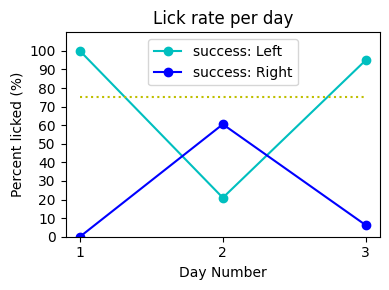

In [9]:
mouseID = directory.split('/')[6]
export_path = f"X:/Raymond Lab/1_Kai/3_processed_data/3_lick_rates/{stage}/{mouseID}.png"
plot = plot_array(sorted(lick_rate),stage, export_path)

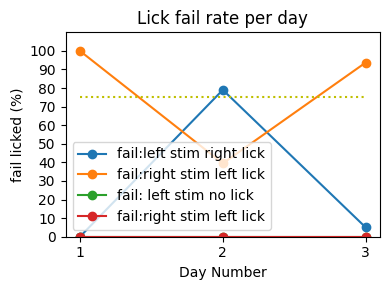

In [10]:
if stage == "stage3":
    plot2 = plot_fail(sorted(lick_rate),stage)